<a href="https://colab.research.google.com/github/FelixEbenezer/TER/blob/main/Classif_Age_Texte_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION
Pour ce deuxieme modèle, afin de repondre à la problématique posé par Mr. Sidibé, à savoir développer un modele de prédiction de l´âge(Ados ou Adulte) selon le texte analysé, j´ai choisi 2 algo de machine learning (Naives bayes et un autre de regression  logistique). 
Choix basé par sont élevé taux d´accuracy.


-Dataset: Analyse exploratoire,
Tokenisation,
Pre-processing (Removing stop_word, Removing special charactere, 
Feature engineering( on a choisi de transmer texte traité en vecteurs de int en utilisant le bert tokenisation de tensorflow.keras),
Model building
et enfin Model Evaluation.

In [ ]:
# Etape 1: Importation des bibliothèques nécessaires pour la réalisation de cette tâche

import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

!pip install bert-for-tf2

!pip install sentencepiece

# Commented out IPython magic to ensure Python compatibility.
# %tensorflow_version 2.x

#!pip install tensorflow==2.2.0-rc3
import tensorflow as tf
tf.__version__

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert


## PRE TRAITEMENT DES DONNÉES
## 1. Chargement de la base

In [ ]:
"""# Etapa 2: Pré-traitement de donnés ET ANALYSE EXPLORATOIRE 

## Chargement de la base. La dataset est situé sur google drive vu que j utilise colab, donc ça facilite l accés et l utilisation
"""

drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv("/content/drive/My Drive/dataset_immersion.zip", sep='\t', header=0, index_col=None)
data.shape


(385524, 4)

In [ ]:
#Pour voir la taille et les différentes variables ou colonnes de notre dataset
data.shape
data.columns 

Index(['text', 'clean_text', 'label', 'length'], dtype='object')

In [ ]:
data.head()

,text,clean_text,label,length
0,"Allez, on remet ça !\n\nLONGUE VIE A CE TOPIC",Allez on remet ça LONGUE VIE A CE TOPIC,ados,9
1,oui,oui,ados,1
2,c'est un nouveau départ pour le forum,c'est un nouveau départ pour le forum,ados,7
3,On prend les mêmes et on recommence,On prend les mêmes et on recommence,ados,7
4,"y'avait pas une majuscule à ""nuit"" ?",y'avait pas une majuscule à `` nuit '',ados,8


In [ ]:
#On voit que notre dataset est constitué de 4 colonnes text, clean_text, label et length avec 385520 enregistrements ou lignes.
#De ce 4 colonnes, seules 2 (text et label) nous interressent et qui vont constituer notre dataset finale.

In [ ]:
data.drop(['clean_text', 'length'],axis = 1, inplace=True)

In [ ]:
data.shape


(385524, 2)

In [ ]:
#on peut voir ici le format qu aura notre dataset final
data.head()

,text,label
0,"Allez, on remet ça !\n\nLONGUE VIE A CE TOPIC",ados
1,oui,ados
2,c'est un nouveau départ pour le forum,ados
3,On prend les mêmes et on recommence,ados
4,"y'avait pas une majuscule à ""nuit"" ?",ados


In [ ]:
data.tail()


,text,label
385519,heu on a t'as deja repondu ailleurt il me semb...,adult
385520,En réponse à FHL44\nheu on a t'as deja repondu...,adult
385521,"Coucou tout le monde!\nAlors voila,hier soir j...",adult
385522,"concernant le saignement et la douleur, on est...",adult
385523,exusez moi de vous poser ces questions un pe...,adult


In [ ]:
#Desequilibre de notra dataset. On remarque sur le graphique ci dessous, créé avec la bibliotheque seaborn, que notre dataset est constitué de 60mil lignes
#de plus pour les ados que les adults. Ce qui pourra biaiser le résultat de notre modèle car la probabilité est plus du côté des ados.
#On doit donc équilibre notre dataset en faisant data augmentation de la part des adults avec les méthodes telles que Scraping ou autres.
#mais pour question de temps, nous avons choisi de créér une nouvelle basée équilibrée constituée de 50mil ados et 50mil autres pour les adults.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


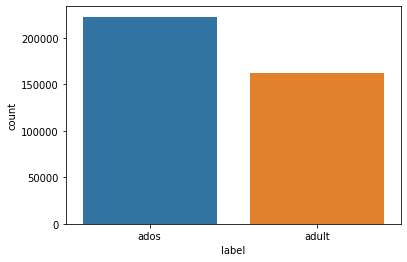

In [ ]:
sns.countplot(data['label']);

In [ ]:
data1 = data[['text', 'label']][:50000]

In [ ]:
data2 = data[['text', 'label']][230000:280000]

In [ ]:
data2.shape

(50000, 2)

In [ ]:
df = pd.concat([data1, data2])

In [ ]:
#Nouvelle base finale constituée et équilibrée avec 100mil enregistrements.
#Voir le graphique ci dessous.

In [ ]:
df.shape

(100000, 2)

In [ ]:
data = df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


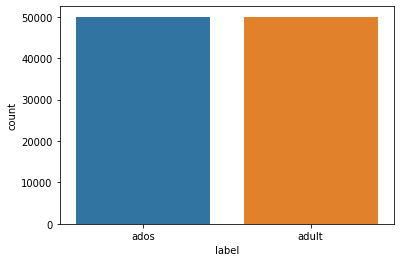

In [ ]:
sns.countplot(data['label']);


# 2. NETTOYAGE

In [ ]:


def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet



In [ ]:
test = '99 ' + data.text[0]
test



'99 Allez, on remet ça !\n\nLONGUE VIE A CE TOPIC'

In [ ]:
result = clean_tweet(test)
result



' Allez on remet a ! LONGUE VIE A CE TOPIC'

In [ ]:
data_clean = [clean_tweet(tweet) for tweet in data.text]



/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.folklorika.cz/fotky/remesla/prouti_3.jpg

..." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
data_clean[0:4]

['Allez on remet a ! LONGUE VIE A CE TOPIC',
 'oui',
 "c'est un nouveau d part pour le forum",
 'On prend les m mes et on recommence']

In [ ]:
#Je transforme en vecteur mes valeurs categorielles
data_labels = data.label.values
data_labels


array(['ados', 'ados', 'ados', ..., 'adult', 'adult', 'adult'],
      dtype=object)

In [ ]:
#Les machines fonctionnent meieux avec des chiffres que des textes, du coup de transforme la valeur categorielle ados en 0 et adult en 1

In [ ]:
data_labels[data_labels == 'ados'] = 0
data_labels

array([0, 0, 0, ..., 'adult', 'adult', 'adult'], dtype=object)

In [ ]:
data_labels[data_labels == 'adult'] = 1

In [ ]:
!pip install sklearn

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


In [ ]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(data_clean)

In [ ]:
data_labels[data_labels == 0] = 'ados'

In [ ]:
data_labels[data_labels == 1] = 'adult'

In [ ]:
data_labels[90000:95000]

array(['adult', 'adult', 'adult', ..., 'adult', 'adult', 'adult'],
      dtype=object)

Nous adaptons notre classificateur Multinomial Naive Bayes sur les données du train pour le former.

In [ ]:
classifier = MultinomialNB()
targets = data_labels.ravel()
classifier.fit(counts, targets)

MultinomialNB()

In [ ]:
examples = ["c est un nouveau départ pour le forum c est un nouveau départ pour le forum		"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
print(predictions)

['ados']


In [ ]:
# Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
# matrix of token counts (CountVectorizer)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data_clean)

# transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
# training our classifier ; train_data.target will be having numbers assigned for each category in train data
clf = MultinomialNB().fit(X_train_tfidf, data_labels)

# Input Data to predict their classes of the given categories
docs_new = ['C est vraiment chelou']
# building up feature vector of our input
X_new_counts = count_vect.transform(docs_new)
# We call transform instead of fit_transform because it's already been fit
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [ ]:
# predicting the category of our input text: Will give out number for category
predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, data_labels))

'C est vraiment chelou' => ['ados' 'ados' 'ados' ... 'adult' 'adult' 'adult']


Nous évaluons enfin notre modèle en prédisant les données de test. De plus, vous verrez comment effectuer toutes les tâches de vectorisation, de transformation et de classification en un seul classificateur composé à l'aide de Pipeline.

In [ ]:
# We can use Pipeline to add vectorizer -> transformer -> classifier all in a one compound classifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
# Fitting our train data to the pipeline
text_clf.fit(data_clean, data_labels)

# Test data 
#test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
#docs_test = test_data.data
# Predicting our test data
predicted = text_clf.predict(data_clean)
print('We got an accuracy of',np.mean(predicted == data_labels)*100, '% over the test data.')

We got an accuracy of 88.587 % over the test data.


In [ ]:
get_prediction("C est vraiment chelou")

Ados
